In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [40]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage
from palin.internal_noise.double_pass import DoublePass
from palin.internal_noise.intercept_method import InterceptMethod
from palin.simulation.simulation import Simulation as Sim
from palin.simulation.analysers.agreement_statistics import AgreementStatistics
from palin.internal_noise.agreement_method import AgreementMethod
from palin.internal_noise.distance_method import DistanceMethod

from palin.kernels.glm_kernel import GLMKernel
from palin.internal_noise.glm_method import GLMMethod


# Three new algorithms to estimate observer internal noise without double-pass measurements

&copy; Aynaz Adl Zarrabi, Jean-Julien Aucouturier, Ladislas Nalborczyk, Marie Villain

## Methods

### Consistency methods

#### Forward and inverse models

- The ideal observer model provides a generative model by which one can simulate the responses given by an observer with a given kernel and internal noise level, to arbitrary stimuli.  
- From these responses, one can evaluate a probability of agreement between duplicated trials (forward model). This model is stochastic: for a given observer, and a given experiment, responses have stochasticity because of internal noise realizations, and so does probability of agreement 
- the task of internal noise estimation from a real observer's response is the inverse model: from an observation of probability of agreement, find the most plausible internal noise level (hidden variable) that would forward-generate this probability
- to extend to the case where observers are biased (i.e a non null response criteria), one can also observe probability of answering the first interval (in a 2AFC design). In which case the forward model maps two hidden variables (internal noise and criteria) to two observations (probability of agreement, and probability of first interval)
- to deal with stochasticity, we compute the expected values of the observations (prob_agree, prob_int1) over several realizations of the same simulated experiment (forward model), and therefore aim to estimate the internal noise and criteria for which the observed probabilities are closest to their expected values
- a typical practical implementation of this procedure is to simulate observers with an arbitrary kernel (ex. a simple scalar) and a grid of internal noise and criteria values, encountering a single experiment for several runs (ex. 100 or 1000), compute the average corresponding probabilities for each internal noise and criteria; store this as a lookup table; then given a real observation of probabilities for a real observer, find the pair of internal noise and criteria that correspond to the closest pair of probabilities in the table. 

<Axes: xlabel='criteria', ylabel='internal_noise_std'>

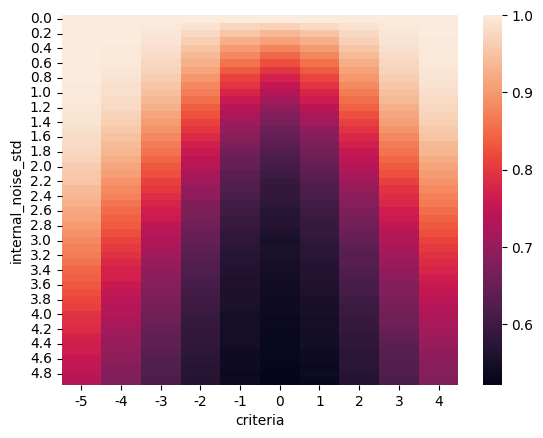

In [44]:
model_df = pd.read_csv('./agreement_model_large.csv')
model_df.internal_noise_std = model_df.internal_noise_std.map(lambda x: '%.1f'%x)

sns.heatmap(data=model_df.pivot(index="internal_noise_std", columns="criteria", values="prob_agree"))



<Axes: xlabel='criteria', ylabel='internal_noise_std'>

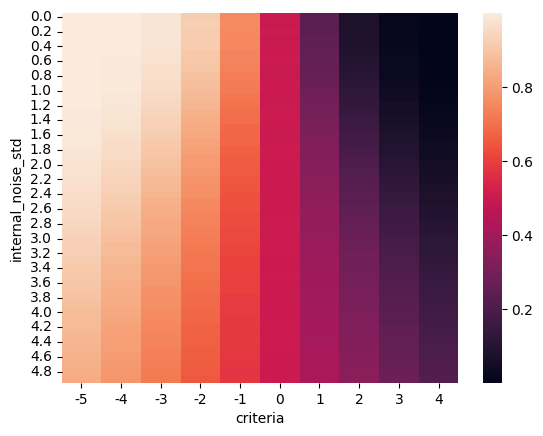

In [45]:
sns.heatmap(data=model_df.pivot(index="internal_noise_std", columns="criteria", values="prob_first"))

Rarely asked questions: 
- is it invertible ?
- effect of nb of runs, or nb of trials for the forward model
- effect of bounds (saturate at 5, or 10)
- difference between using actual experimental trials vs simulated experiment
- same n_trials of experiment, or as large as possible ?
- <mark> for Ladislas: </mark> comment utiliser DEOptim avec un système stochastique ?

In [97]:
model_df = pd.read_csv('./agreement_model_large.csv')
model_df.internal_noise_std = model_df.internal_noise_std.map(lambda x: '%.1f'%x)

model_df.pivot(index="prob_agree", columns="prob_first", values="internal_noise_std")

#sns.heatmap(data=model_df.pivot(index="prob_agree", columns="prob_first", values="internal_noise_std"))

prob_first,0.00191,0.00210,0.00226,0.00261,0.00290,0.00356,0.00429,0.00577,0.00696,0.00861,...,0.99846,0.99886,0.99933,0.99953,0.99961,0.99963,0.99966,0.99974,0.99975,0.99988
prob_agree,,,,,,,,,,,,,,,,,,,,,
0.52124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.52906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.53020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.99954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN
0.99984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN
0.99986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN


##### Effect of nb of runs & nb of trials

In short, as soon as you do n_runs > 1 (ex. 10), then the nb of trials (100,500,1000) doesn't have an impact that's larger than the inherent stochasticity of the system (i.e. any difference is < confidence interval over the runs). However, increasing both n trials and n runs increases the stability of the estimate. Globally, it tends to underestimate large (>3) internal noise values, exponentially so as we get closer to the bounds. 
-> **recommendation** we use 1000 trials, 20 runs in the following ?

In [79]:
for n_runs in [1, 10, 20]: 
    for n_trials in [100, 500, 1000]: 
        AgreementMethod.build_model(agreement_model_file = './model_trials_%d_runs_%d.csv'%(n_trials, n_runs),
                            internal_noise_range=np.arange(0,5,.1),
                            criteria_range=np.arange(-5,5,.5), 
                            n_repeated_trials=n_trials, 
                            n_runs=n_runs) 

Building double-pass model


100%|██████████| 1000/1000 [00:35<00:00, 28.40it/s]


Building double-pass model


100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Building double-pass model


100%|██████████| 1000/1000 [07:25<00:00,  2.25it/s]


Building double-pass model


100%|██████████| 10000/10000 [07:30<00:00, 22.18it/s]


Building double-pass model


100%|██████████| 10000/10000 [31:57<00:00,  5.22it/s]


Building double-pass model


100%|██████████| 10000/10000 [1:01:02<00:00,  2.73it/s]


Building double-pass model


100%|██████████| 20000/20000 [12:54<00:00, 25.84it/s]


Building double-pass model


100%|██████████| 20000/20000 [1:01:20<00:00,  5.43it/s]


Building double-pass model


100%|██████████| 20000/20000 [2:12:16<00:00,  2.52it/s]  


In [69]:
def parse_model_file_name(file_name):
    tokens = os.path.splitext(file_name)[0].split('_')
    return tokens[2], tokens[4]

parse_model_file_name('./model_trials_10_runs_20.csv')

('10', '20')

In [80]:
models = []
for n_runs in [1, 10, 20]: 
    for n_trials in [100, 500, 1000]: 
        models.append('./model_trials_%d_runs_%d.csv'%(n_trials, n_runs))
        
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[100], 
                     'n_repeated':[100],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'agreement_model_file':models}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all(n_runs=100)

sim_df['n_trials_model'] = sim_df.agreement_model_file.map(lambda x: parse_model_file_name(x)[0])
sim_df['n_runs_model'] = sim_df.agreement_model_file.map(lambda x: parse_model_file_name(x)[1])

sim_df.to_csv('./sim_internal_noise.csv')


100%|██████████| 45900/45900 [32:15<00:00, 23.72it/s]


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\2670732256.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '1000 trials')

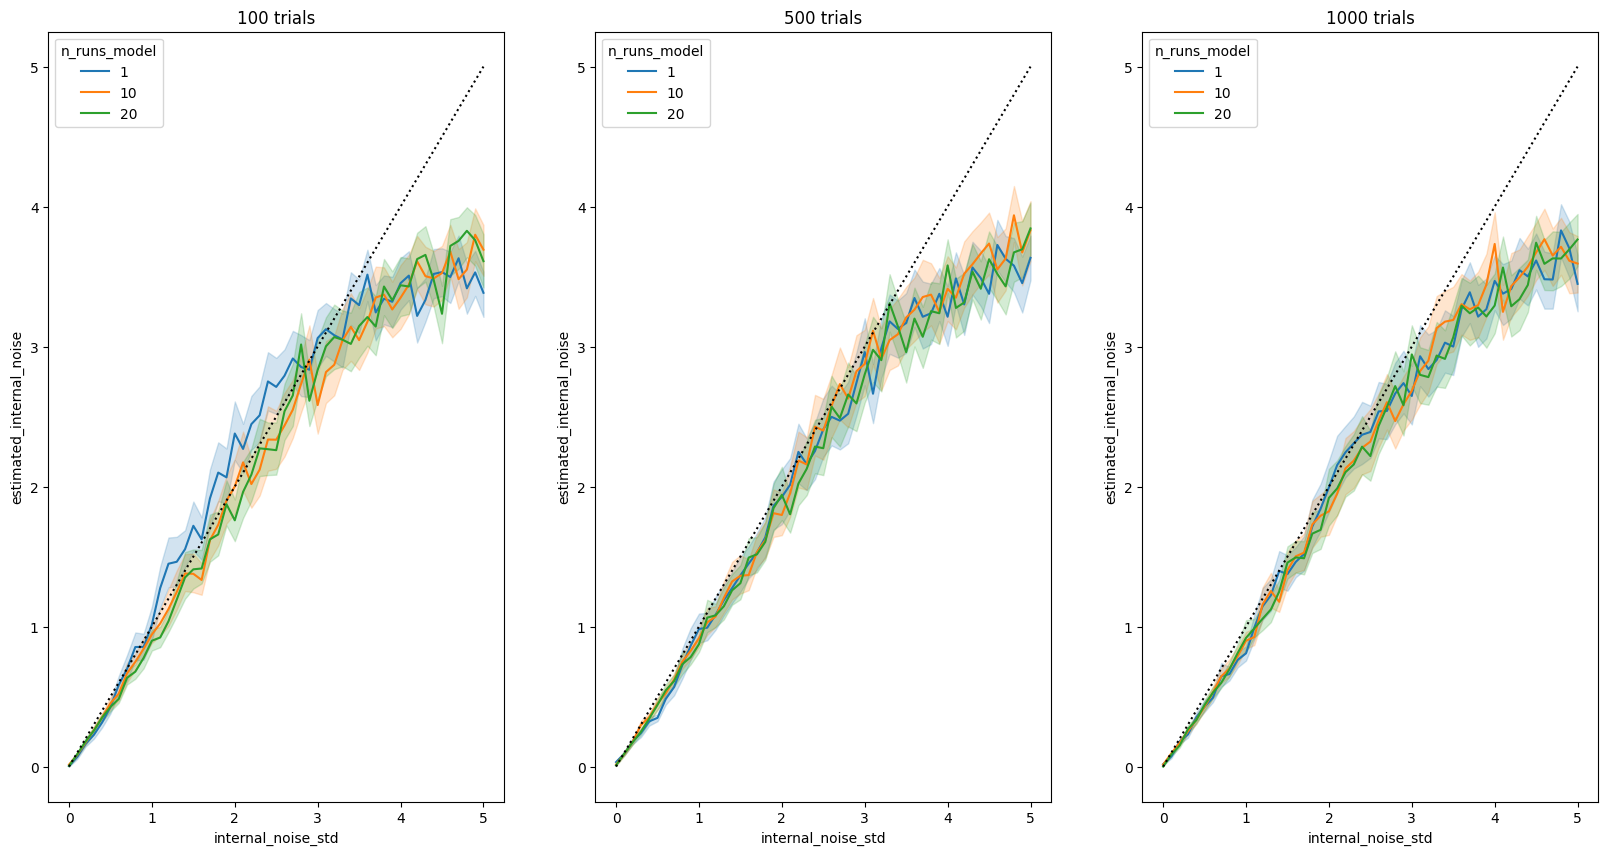

In [88]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='100'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('100 trials')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='500'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('500 trials')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='1000'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_runs_model')
plt.plot([0,5],[0,5],'k:')
plt.title('1000 trials')

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\2703386166.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '20 trials')

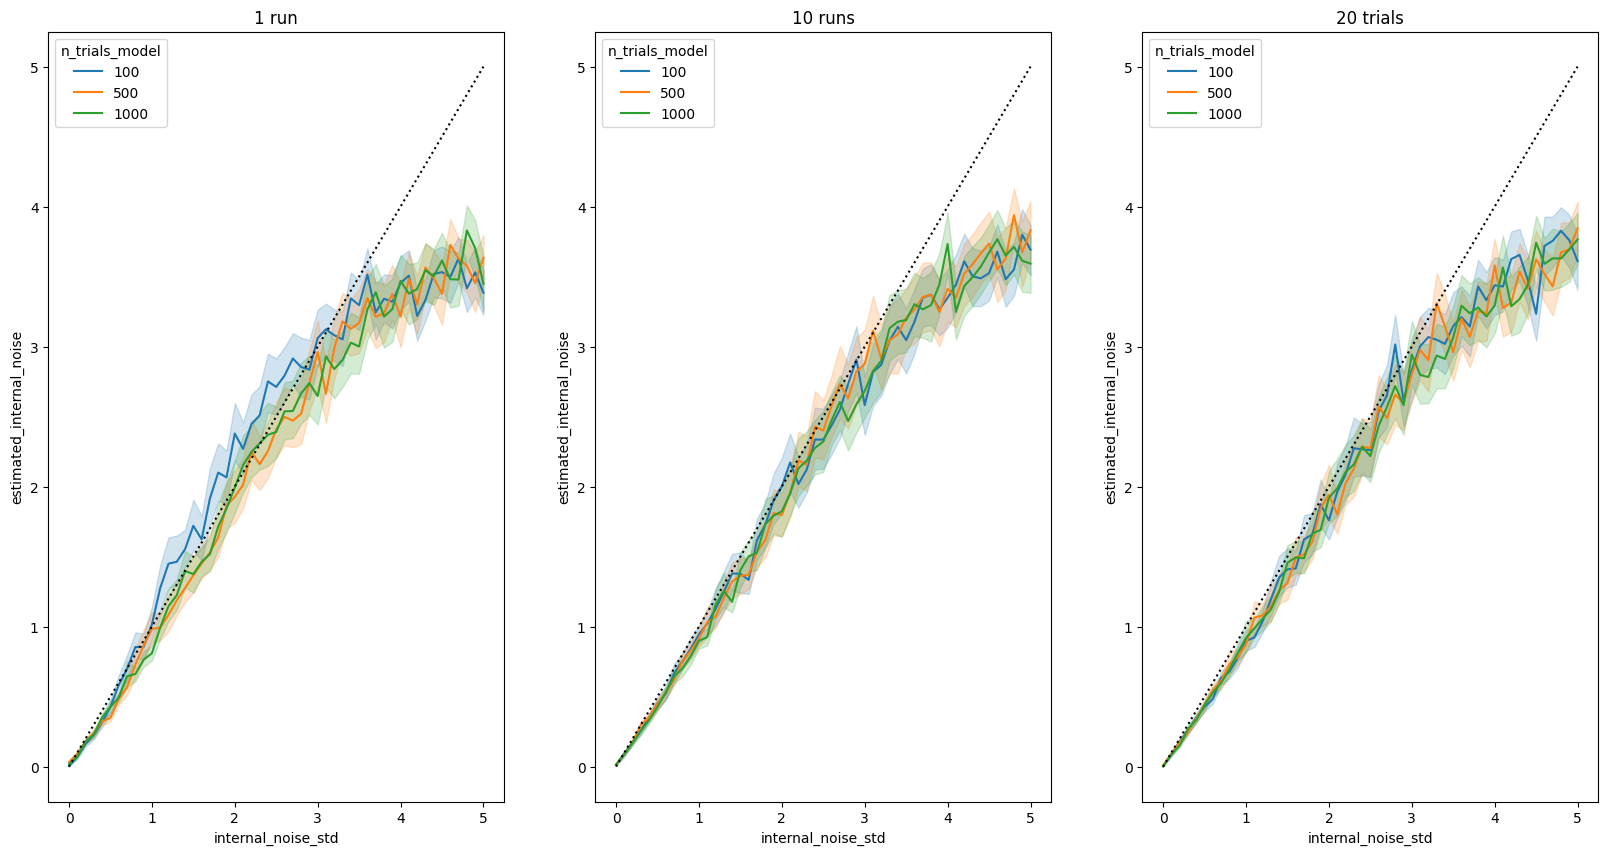

In [89]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='1'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('1 run')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='10'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('10 runs')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='20'], 
             x='internal_noise_std',
             y='estimated_internal_noise', hue='n_trials_model')
plt.plot([0,5],[0,5],'k:')
plt.title('20 trials')

In [91]:
sim_df['internal_noise_error'] = sim_df.estimated_internal_noise - sim_df.internal_noise_std

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\248889569.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '1000 trials')

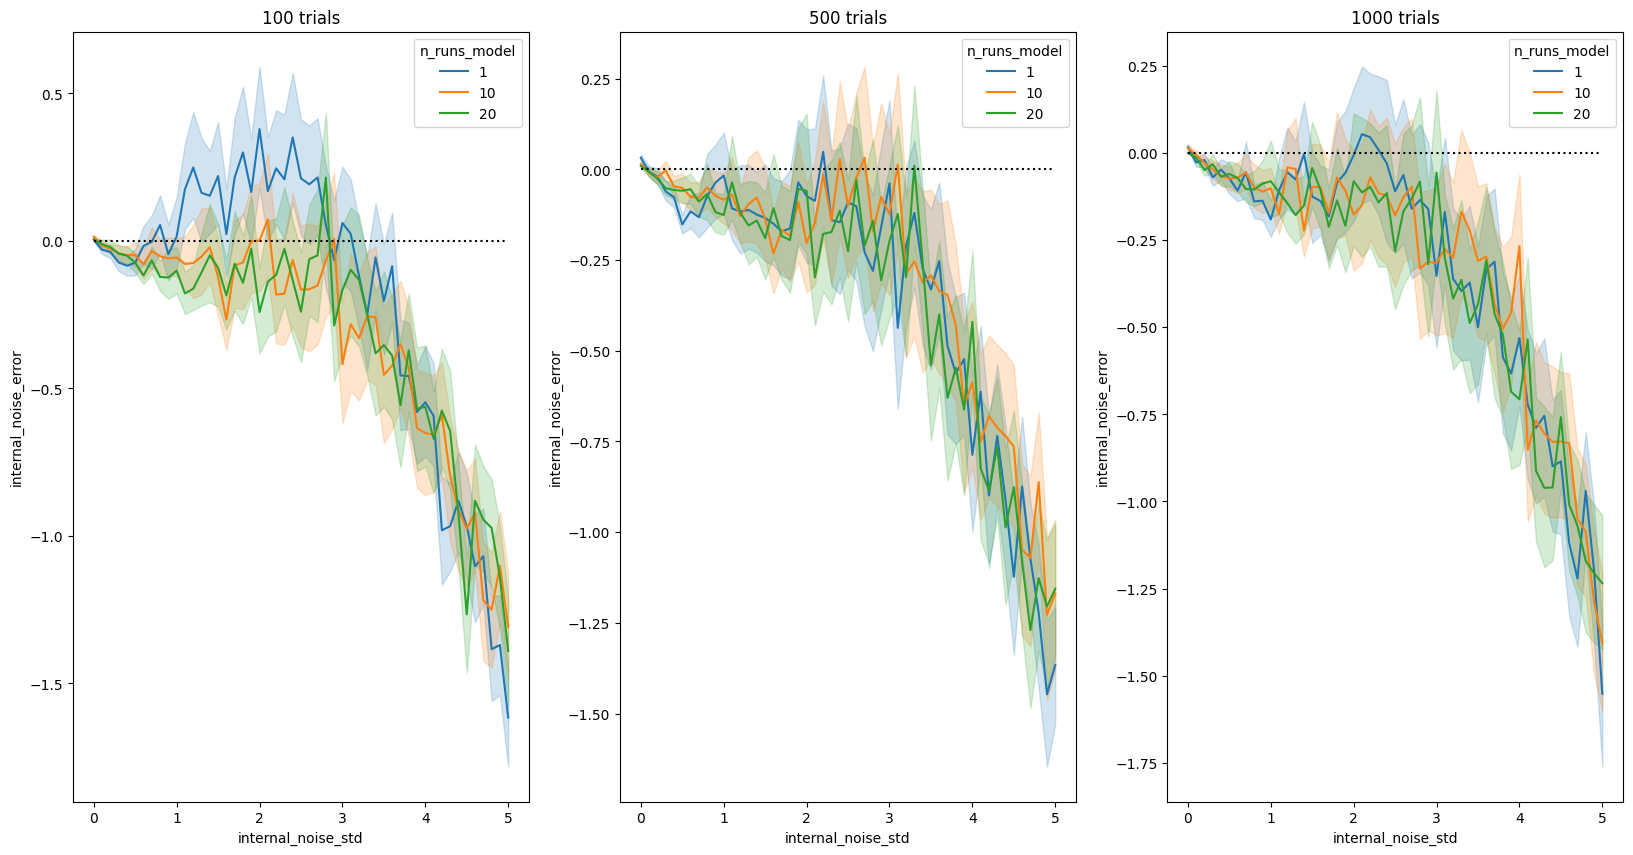

In [93]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='100'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('100 trials')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='500'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('500 trials')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_trials_model=='1000'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_runs_model')
plt.plot([0,5],[0,0],'k:')
plt.title('1000 trials')

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_1744\3905749762.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


Text(0.5, 1.0, '20 trials')

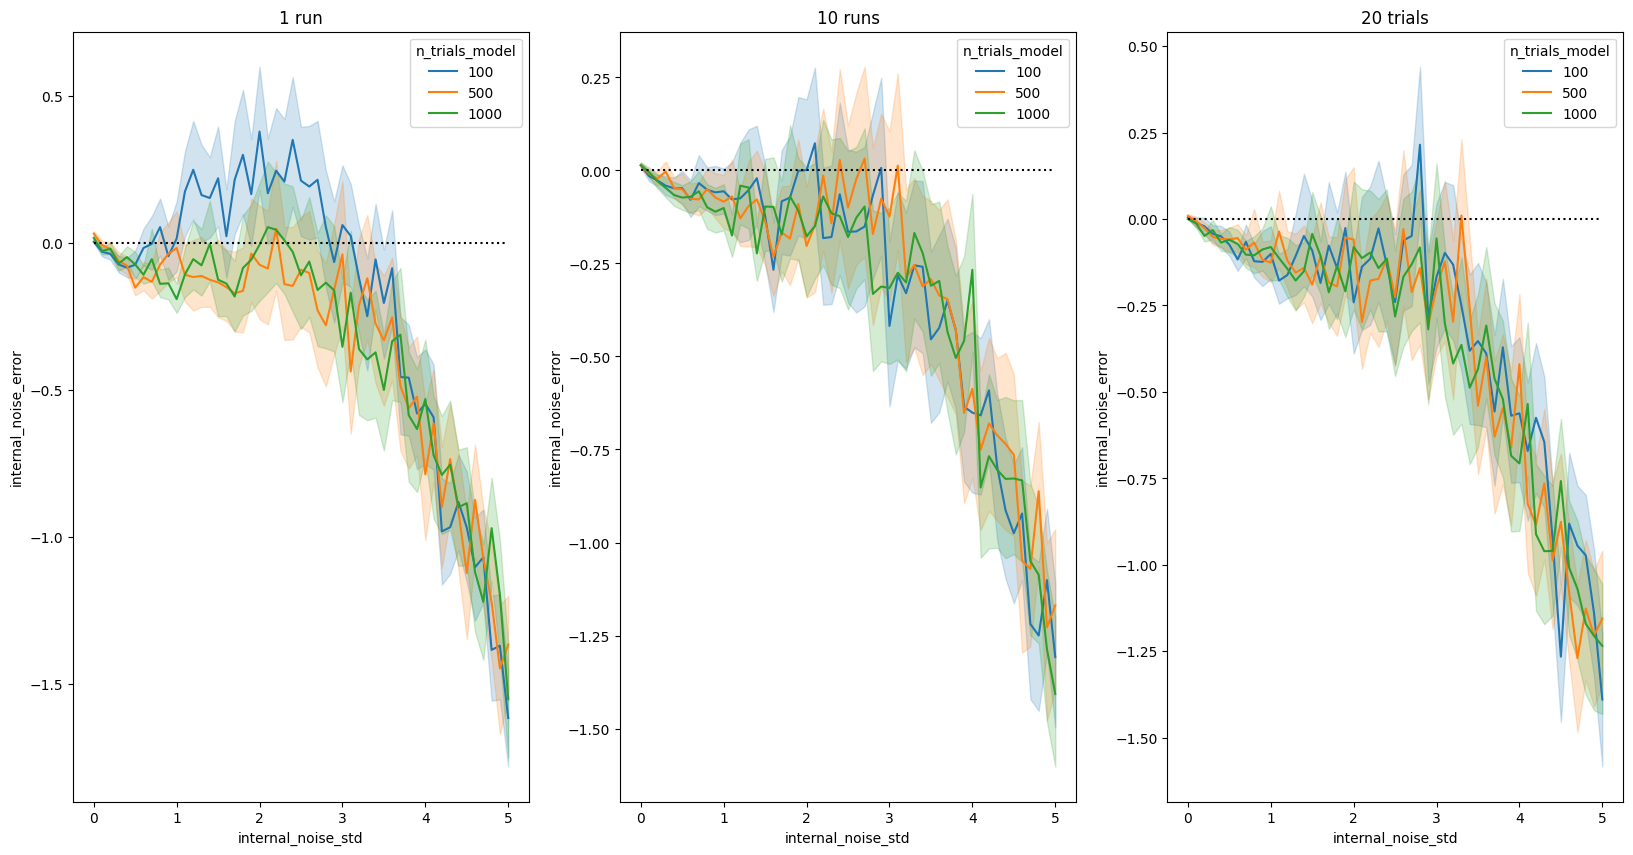

In [94]:
plt.subplots(figsize=(20,10))
plt.subplot(1,3,1)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='1'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('1 run')
plt.subplot(1,3,2)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='10'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('10 runs')
plt.subplot(1,3,3)
sns.lineplot(data=sim_df[sim_df.n_runs_model=='20'], 
             x='internal_noise_std',
             y='internal_noise_error', hue='n_trials_model')
plt.plot([0,5],[0,0],'k:')
plt.title('20 trials')

## Results

### Intercept

On choisit les meilleurs paramètres avec RMSE vs double pass p_agree

In [7]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[InterceptMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'bin_data':[True,False],
                   'n_bins':[10,50, 100],
                   'fit_method':['poly','glm']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_df = sim.run_all(n_runs=1)

100%|██████████| 1224/1224 [23:16<00:00,  1.14s/it] 


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\479057705.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(0.5, 1.1)

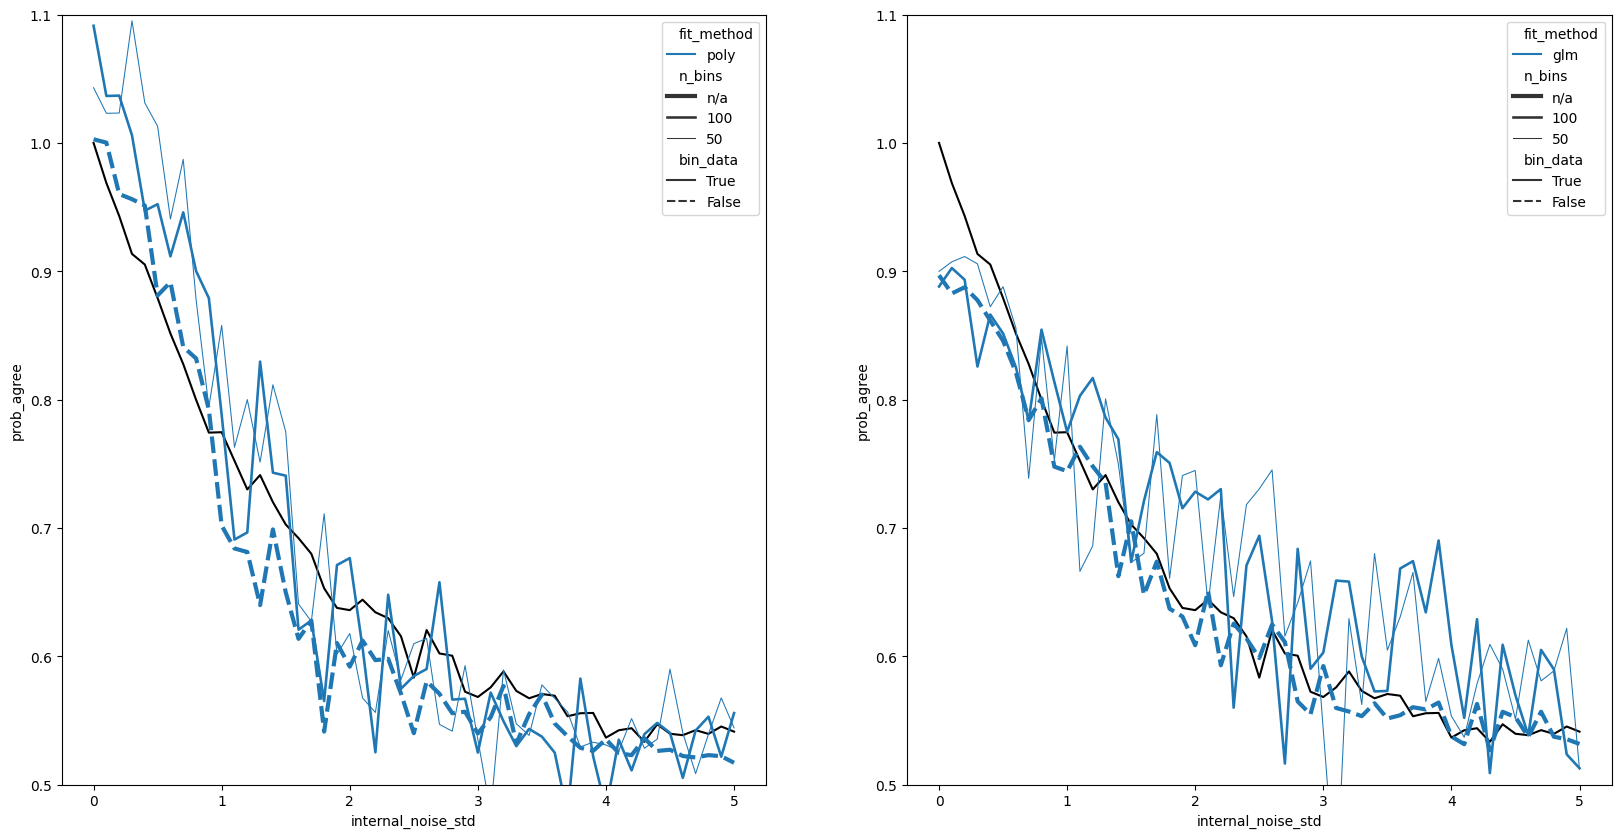

In [25]:
plt.subplots(figsize=(20,10))

plt.subplot(1,2,1)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                   &(sim_df.bin_data==False)].groupby(['internal_noise_std','fit_method', 'bin_data'],
                                                      as_index=False).prob_agree.mean()
test_data['n_bins'] = 'n/a'
test_data = pd.concat([test_data, sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                                         &(sim_df.bin_data==True)]])
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='fit_method', hue_order = ['poly'], size='n_bins', size_order=['n/a',100,50], style='bin_data', style_order=[True,False])

plt.ylim([0.5,1.1])
plt.subplot(1,2,2)

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                   &(sim_df.bin_data==False)].groupby(['internal_noise_std','fit_method', 'bin_data'],
                                                      as_index=False).prob_agree.mean()
test_data['n_bins'] = 'n/a'
test_data = pd.concat([test_data, sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                                         &(sim_df.bin_data==True)]])
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='fit_method', hue_order = ['glm'], size='n_bins', size_order=['n/a',100,50], style='bin_data', style_order=[True,False])

plt.ylim([0.5,1.1])


In [31]:
# compute RMSE vs dblepass
ground_truth = sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()
for fit_method in ['poly','glm']: 
    print('%s'%fit_method.upper())
    for bin_data in [True,False]:
        print('bin: %s'%bin_data)
        for n_bins in [10,50, 100]: 
            test_data = sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                               &(sim_df.bin_data==bin_data)
                               &(sim_df.n_bins == n_bins)
                               &(sim_df.fit_method==fit_method)].groupby(['internal_noise_std'],
                                                      as_index=False).prob_agree.mean()
            rmse = np.sqrt((test_data.sort_values(by='internal_noise_std').prob_agree
                            - ground_truth.sort_values(by='internal_noise_std').prob_agree).pow(2).mean())
                        
            print('n_bins %d: %.3f '%(n_bins,rmse))
        


POLY
bin: True
n_bins 10: 0.138 
n_bins 50: 0.061 
n_bins 100: 0.055 
bin: False
n_bins 10: 0.047 
n_bins 50: 0.046 
n_bins 100: 0.043 
GLM
bin: True
n_bins 10: 0.186 
n_bins 50: 0.068 
n_bins 100: 0.066 
bin: False
n_bins 10: 0.036 
n_bins 50: 0.039 
n_bins 100: 0.037 


Sous-question: est-ce que poly avec nbins >100 est meilleur que glm no bin

In [32]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[InterceptMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'bin_data':[True],
                   'n_bins':[50,100,200,500,1000],
                   'fit_method':['poly']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_2_df = sim.run_all(n_runs=1)

100%|██████████| 510/510 [09:25<00:00,  1.11s/it]


n_bins 50: 0.037 
n_bins 100: 0.027 
n_bins 200: 0.028 
n_bins 500: 0.036 
n_bins 1000: 0.028 


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_17924\2457237899.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ground_truth = sim_2_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'],


<Axes: xlabel='n_bins', ylabel='rmse'>

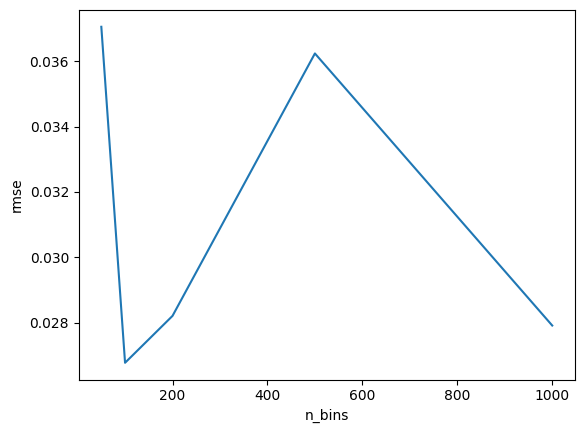

In [38]:
# compute RMSE vs dblepass
ground_truth = sim_2_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()

n_bins = []
rmses = []
for n_bin in [50,100,200,500,1000]:
    
    test_data = sim_2_df[(sim_2_df.n_bins == n_bin)].groupby(['internal_noise_std'],
                                                      as_index=False).prob_agree.mean()
    rmse = np.sqrt((test_data.sort_values(by='internal_noise_std').prob_agree
                            - ground_truth.sort_values(by='internal_noise_std').prob_agree).pow(2).mean())
        
    n_bins.append(n_bin)
    rmses.append(rmse)
            
    print('n_bins %d: %.3f '%(n_bin,rmse))
        
data_df = pd.DataFrame.from_dict({'n_bins':n_bins,'rmse':rmses})
sns.lineplot(data=data_df,
            x='n_bins', y='rmse')
        

### Distance method

In [41]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DistanceMethod, DoublePass],
                   'kernel_extractor':[ClassificationImage],
                  'method':['accuracy'],
                   'trial_mask':['all','hit','cr'],
                   'weight_trials':[True,False]}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          AgreementStatistics, analyser_params)

sim_df = sim.run_all(n_runs=1)

100%|██████████| 612/612 [02:25<00:00,  4.19it/s]


<Axes: xlabel='internal_noise_std', ylabel='prob_agree'>

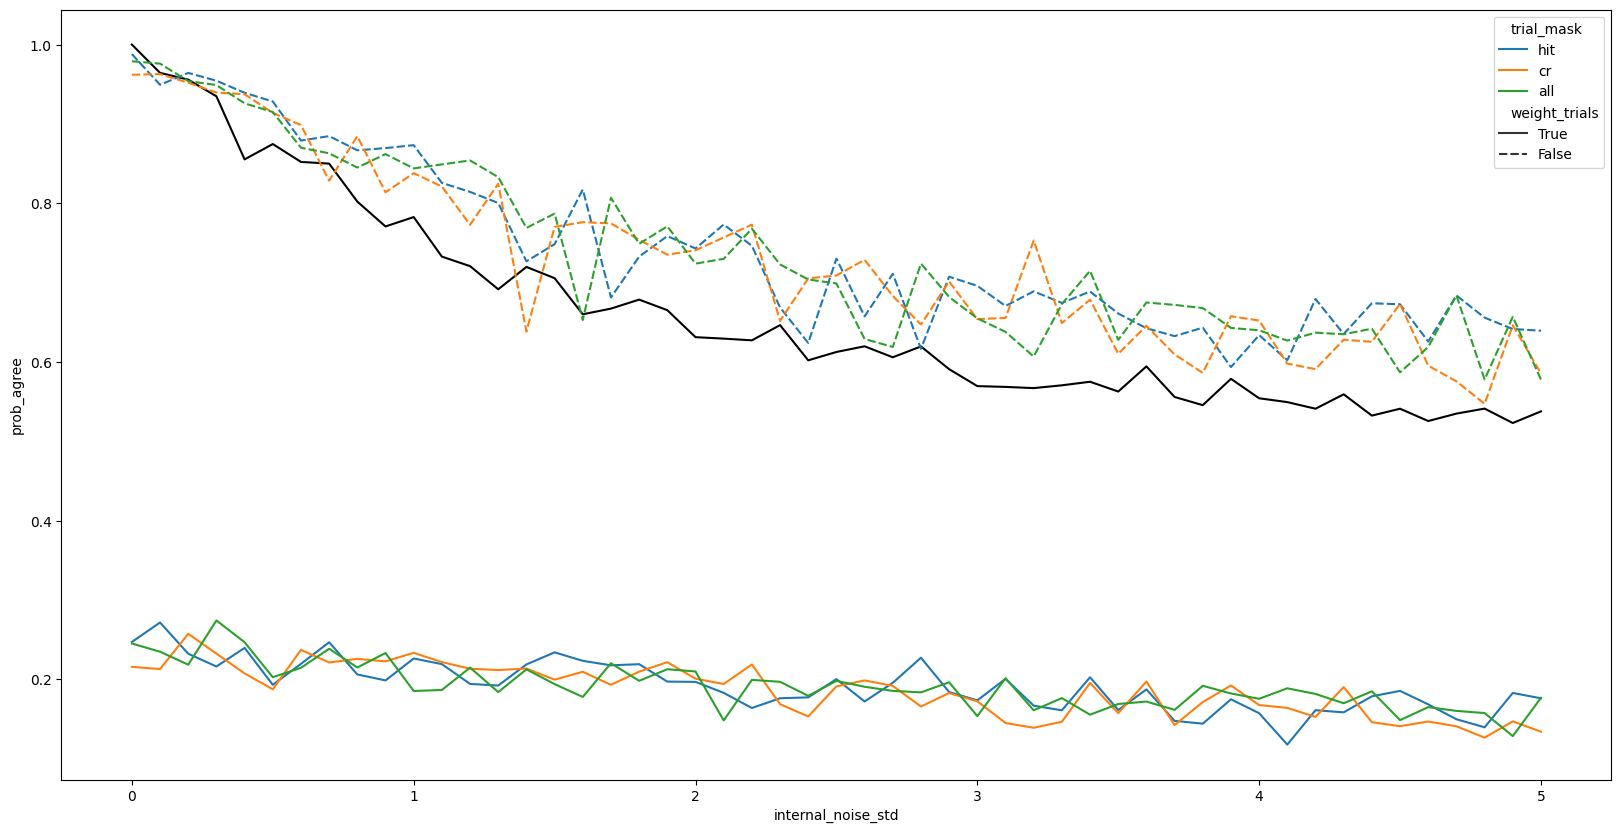

In [42]:
plt.subplots(figsize=(20,10))

sns.lineplot(data=sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean(), 
            x="internal_noise_std", 
            y='prob_agree',  color='black')

test_data = sim_df[(sim_df.internal_noise_extractor==DistanceMethod)].groupby(['internal_noise_std',
                                                                               'trial_mask',
                                                                               'weight_trials'],
                                                      as_index=False).prob_agree.mean()
                       
sns.lineplot(data=test_data, 
            x="internal_noise_std", 
            y='prob_agree', 
            hue='trial_mask', hue_order = ['hit','cr','all'], 
             style='weight_trials', style_order=[True,False])



In [61]:
dbl_pass_df.internal_noise_std.unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [62]:
dbl_pass_df = sim_df[sim_df.internal_noise_extractor==DoublePass].groupby(['internal_noise_std'], 
                                                                              as_index=False).prob_agree.mean()
dbl_pass_df.internal_noise_std = internal_noise_std.astype(float)
new_df = sim_df.join(dbl_pass_df,on='internal_noise_std', rsuffix='_DP')

sns.lineplot(data=new_df, 
            x="prob_agree_DP", 
            y='prob_agree', 
            hue='trial_mask', hue_order = ['hit','cr','all'], 
             style='weight_trials', style_order=[True,False])



NameError: name 'internal_noise_std' is not defined

### Comparison of all methods

Attention à comparer les méthodes à durée équivalente (cad 500+500 pour dble pass et 1000+* pour les autres)

In [ ]:
experiment_params = {'n_trials':[500, 1000], 
                     'n_repeated':[500],
